Clone TACO repository

In [ ]:
!git clone https://github.com/pedropro/TACO

#Download h5 file and your own images and store it in the root directory (So outside of the TACO folder)

We are using taco_10_3.zip
https://github.com/pedropro/TACO/releases/tag/1.0

Install to prevent future errors

In [ ]:
!pip install keras==2.1.6

In [ ]:
!pip install 'h5py==2.10.0'

In [ ]:
%tensorflow_version 1.x

Load class map and print classes

In [ ]:
%cd TACO/detector/

In [ ]:
## Load Dataset
import csv
import dataset

# Load class map - these tables map the original TACO classes to your desired class system
# and allow you to discard classes that you don't want to include.
class_map = {}
with open("taco_config/map_10.csv") as csvfile:
    reader = csv.reader(csvfile)
    class_map = {row[0]:row[1] for row in reader}

# Load full dataset or a subset
TACO_DIR = "../data"
round = None # Split number: If None, loads full dataset else if int > 0 selects split no 
subset = "train" # Used only when round !=None, Options: ('train','val','test') to select respective subset
dataset = dataset.Taco()
taco = dataset.load_taco(TACO_DIR, round, subset, class_map=class_map, return_taco=True)

# Must call before using the dataset
dataset.prepare()

print("Class Count: {}".format(dataset.num_classes))
for i, info in enumerate(dataset.class_info):
    print("{:3}. {:50}".format(i, info['name']))

Create config class and override settings

In [ ]:
from config import Config
class TacoTestConfig(Config):
    NAME = "taco"
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    DETECTION_MIN_CONFIDENCE = 0.3
    NUM_CLASSES = 11

config = TacoTestConfig()
config.display()

Create a model and load the pre-trained weights

#module 'keras.engine.topology' has no attribute 'load_weights_from_hdf5_group_by_name'

FIX: In model.py, lines 2213, 2235, 2237 change 'topology' with 'saving'

AFTER: Reset runtime and run all lines from "%tensorflow_version 1.x" and below.

In [ ]:
import model as modellib

model = modellib.MaskRCNN(mode="inference", model_dir='mask_rcnn_coco.hy', config=config)

model.load_weights('../../mask_rcnn_taco_0100.h5', by_name=True, weights_out_path=None)

Load your custom image and display it

Make sure to change the name of the image to match yours

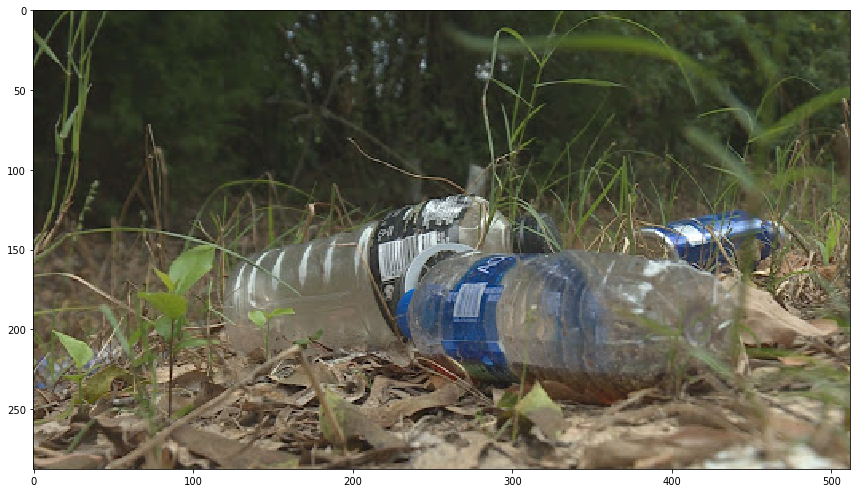

In [6]:
%matplotlib inline
import skimage.io
import matplotlib.pyplot as plt

image = skimage.io.imread('../../trash2.jpg')

plt.figure(figsize=(12,10))

skimage.io.imshow(image)

Load annotations.json and print all category names

In [7]:
import json
dataset_path = '../data'
anns_file_path = dataset_path + '/' + 'annotations.json'

with open(anns_file_path, 'r') as f:
    dataset = json.loads(f.read())

categories = dataset['categories']
anns = dataset['annotations']
imgs = dataset['images']
nr_cats = len(categories)
nr_annotations = len(anns)
nr_images = len(imgs)

cat_names = []
super_cat_names = []
super_cat_ids = {}
super_cat_last_name = ''
nr_super_cats = 0
for cat_it in categories:
    cat_names.append(cat_it['name'])
    super_cat_name = cat_it['supercategory']

    if super_cat_name != super_cat_last_name:
        super_cat_names.append(super_cat_name)
        super_cat_ids[super_cat_name] = nr_super_cats
        super_cat_last_name = super_cat_name
        nr_super_cats += 1

print('Number of super categories:', nr_super_cats)
print('Number of categories:', nr_cats)
print('Number of annotations:', nr_annotations)
print('Number of images:', nr_images)
categories = []
for category in dataset['categories']:
  categories.append(category['name'])
class_names = categories
print(class_names)

Number of super categories: 28
Number of categories: 60
Number of annotations: 4784
Number of images: 1500
['Aluminium foil', 'Battery', 'Aluminium blister pack', 'Carded blister pack', 'Other plastic bottle', 'Clear plastic bottle', 'Glass bottle', 'Plastic bottle cap', 'Metal bottle cap', 'Broken glass', 'Food Can', 'Aerosol', 'Drink can', 'Toilet tube', 'Other carton', 'Egg carton', 'Drink carton', 'Corrugated carton', 'Meal carton', 'Pizza box', 'Paper cup', 'Disposable plastic cup', 'Foam cup', 'Glass cup', 'Other plastic cup', 'Food waste', 'Glass jar', 'Plastic lid', 'Metal lid', 'Other plastic', 'Magazine paper', 'Tissues', 'Wrapping paper', 'Normal paper', 'Paper bag', 'Plastified paper bag', 'Plastic film', 'Six pack rings', 'Garbage bag', 'Other plastic wrapper', 'Single-use carrier bag', 'Polypropylene bag', 'Crisp packet', 'Spread tub', 'Tupperware', 'Disposable food container', 'Foam food container', 'Other plastic container', 'Plastic glooves', 'Plastic utensils', 'Pop t

Create list of all class names

In [ ]:
class_names = ["BG","Bottle","Bottle cap","Can","Cigarette","Cup",
               "Lid","Other","Plastic bag + wrapper","Pop tab","Straw"]

Use model.detect to make predictions and print the index of class names

In [ ]:
r = model.detect([image], verbose=0)[0]
print(r['class_ids'])

Display the image with masks

In [ ]:
import visualize
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], class_names, r['scores'])